## step1. 設定需要使用的程式庫和參數

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision.io import ImageReadMode
from torchvision import transforms

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import numpy as np
import random
import os, glob, math

TRAIN_DIR = os.path.join("train")
TEST_DIR = os.path.join("test")
CROPPED_IMG_SIZE = (28, 28)
NUM_CLASSES = 10
CROP_THRES = 0.9
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## step2. 實做需要使用的 Loader

In [2]:
class LazyLoader:
    def __init__(self, base_path=None):
        self.task = list()
        self.done = list()
        self.size = 0

        if not base_path is None:
            for png_path in glob.glob(os.path.join(base_path, "*.png")):
                filename_without_postfix = png_path[:-4]
                base_path = filename_without_postfix
                txt_path = "{}.txt".format(filename_without_postfix)
                self.done.append((png_path, txt_path, base_path))
                self.size += 1
            assert self.size >= 1, ""

    def reset(self):
        while len(self.task) > 0:
            self.done.append(self.task.pop())

    def split(self, r = 0.1):
        self.reset()

        random.shuffle(self.task)
        split_size = round(r * len(self.done))
        split_buf = self.done[:split_size]
        self.done = self.done[split_size:]
        self.size = len(self.done)

        split_loader = type(self)()
        split_loader.done = split_buf
        split_loader.size = len(split_loader.done)
        return split_loader

    def look(self, batches):
        for i in range(batches):
            img, tgt, _ = self._load_next_data()
            plt.imshow(img.permute(1, 2, 0))
            plt.title("image")
            plt.show()

    def _load_next_data(self, stop=False):
        if len(self.task) == 0:
            self.task, self.done = self.done, self.task
            random.shuffle(self.task)
            if stop:
                return None, None, None

        query = self.task.pop()
        self.done.append(query)
        png_path, txt_path, base_path = query

        img = torchvision.io.read_image(png_path, mode=ImageReadMode.GRAY)
        img = img.float() / 255.
 
        try:
            with open(txt_path, "r") as f:
                tgt = list()
                for line in f.readlines():
                    info = line.strip().split()
                    label = info[0]
                    box = info[1:]
                    tgt.append((label, box))
        except:
            tgt = None

        return img, tgt, base_path

    def sample(self, batches):
        raise NotImplementedError()

    def __len__(self):
        return self.size

class DetectionLoader(LazyLoader):
    def __init__(self, base_path=None):
        super(DetectionLoader, self).__init__(base_path)

    def sample(self, batches):
        imgs, tmaps = list(), list()
        for i in range(batches):
            img, tgt, _ = self._load_next_data()
            tmap = self._make_map(img, tgt)
            imgs.append(img)
            tmaps.append(tmap)
        return torch.stack(imgs).float(), torch.stack(tmaps).float()

    def _make_map(self, img, tgt):
        _, h, w = img.shape
        tmap = torch.zeros((2, h, w)).to(img.device)
        tmap[0, :, :] = 1
        for _, box in tgt:
            xx = round(w * float(box[0]))
            yy = round(h * float(box[1]))
            ww = round(w * float(box[2]))
            hh = round(h * float(box[3]))
            tmap[0, yy:yy+hh, xx:xx+ww] = 0
            tmap[1, yy:yy+hh, xx:xx+ww] = 1
        return tmap

class ClassifyLoader(LazyLoader):
    def __init__(self, base_path=None):
        super(ClassifyLoader, self).__init__(base_path)
        self.img_size = CROPPED_IMG_SIZE
        self._t = transforms.Compose([
            transforms.Resize(size=self.img_size)
        ])

    def sample(self, batches):
        crops, labels = list(), list()
        for i in range(batches):
            img, tgt, _ = self._load_next_data()
            crop, label = self._crop_img(img, tgt)
            crops.append(crop)
            labels.append(label)
        return torch.stack(crops).float(), torch.as_tensor(labels).long()

    def _crop_img(self, img, tgt):
        select = random.randint(0, len(tgt)-1)
        label, box = tgt[select]

        _, h, w = img.shape
        xx = round(w * float(box[0]))
        yy = round(h * float(box[1]))
        ww = round(w * float(box[2]))
        hh = round(h * float(box[3]))

        cropped_img = torch.zeros((1, hh, ww)).to(img.device)
        cropped_img[0, :, :] = img[0, yy:yy+hh, xx:xx+ww]
        cropped_img = self._t(cropped_img)
        return cropped_img, int(label)

class PredictionSetLoader(LazyLoader):
    def __init__(self, base_path=None):
        super(PredictionSetLoader, self).__init__(base_path)
        self.end = False

    def sample(self, batches):
        imgs = list()
        paths = list()
        while len(imgs) < batches:
            img, _, path = self._load_next_data(True)
            if img is None and len(imgs) == 0:
                continue
            elif img is None and len(imgs) > 0:
                self.end = True
                break

            imgs.append(img)
            paths.append(path)
        return torch.stack(imgs).float(), paths


## step3. 定義網路結構

In [3]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels,
                       out_channels,
                       kernel_size,
                       activation=None):
        super(ConvBlock, self).__init__()
        self.act = activation
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            padding="same",
            bias=False,
        )
        self.bn = nn.BatchNorm2d(
            out_channels,
            eps=1e-5
        )
        nn.init.kaiming_normal_(self.conv.weight,
                                mode="fan_out",
                                nonlinearity="relu")
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if not self.act is None:
            x = self.act(x)
        return x

class DoubleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConvBlock, self).__init__()
        mid_channels = out_channels // 2
        self.double_conv = nn.Sequential(
            ConvBlock(in_channels, mid_channels, 7, nn.SiLU(inplace=True)),
            ConvBlock(mid_channels, out_channels, 7, nn.SiLU(inplace=True))
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConvBlock(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.out_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding="same")
        )

    def forward(self, x):
        return self.out_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.mid_channels = [8, 16, 32]

        self.inc   = DoubleConvBlock(in_channels, self.mid_channels[0])
        self.down1 = Down(self.mid_channels[0], self.mid_channels[1])
        self.down2 = Down(self.mid_channels[1], self.mid_channels[2])
        self.up2   = Up(self.mid_channels[2], self.mid_channels[1])
        self.up1   = Up(self.mid_channels[1], self.mid_channels[0])
        self.outc  = OutConv(self.mid_channels[0], num_classes)
        self.softmax = nn.Softmax(dim=1)

    @torch.no_grad()
    def get_prob(self, x):
        return self.softmax(self.forward(x))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x = self.down2(x2)
        x = self.up2(x, x2)
        x = self.up1(x, x1)
        logits = self.outc(x)
        return logits

class FullyConnect(nn.Module):
    def __init__(self, in_size, out_size, activation=None):
        super(FullyConnect, self).__init__()
        self.act = activation
        self.linear = nn.Linear(in_size, out_size)

    def forward(self, x):
        x = self.linear(x)
        if not self.act is None:
            x = self.act(x)
        return x

class ClassifyNet(nn.Module):
    def __init__(self, img_size, num_classes):
        super(ClassifyNet, self).__init__()
        self.img_size = img_size
        h, w = self.img_size
        self.layers = nn.Sequential(
            ConvBlock(1, 32, 5, nn.SiLU(inplace=True)),
            ConvBlock(32, 32, 5, nn.SiLU(inplace=True)),
            nn.AdaptiveMaxPool2d((h//2, w//2)),
            ConvBlock(32, 64, 3, nn.SiLU(inplace=True)),
            ConvBlock(64, 64, 3, nn.SiLU(inplace=True)),
            nn.AdaptiveMaxPool2d((h//4, w//4)),
            ConvBlock(64, 128, 3, nn.SiLU(inplace=True)),
            ConvBlock(128, 128, 3, nn.SiLU(inplace=True)),
            nn.AdaptiveMaxPool2d((1, 1)),
            nn.Flatten(),
            FullyConnect(128, num_classes)
        )
        self.softmax = nn.Softmax(dim=1)

    @torch.no_grad()
    def get_prob(self, x):
        return self.softmax(self.forward(x))

    @torch.no_grad()
    def get_max(self, x):
        prob = self.get_prob(x)
        _, i = torch.max(prob, 1)
        return i.detach()

    def forward(self, x):
        logits = self.layers(x)
        return logits

## step4. 訓練網路

In [4]:
def train_unet(device):
    t_loader = DetectionLoader(TRAIN_DIR)
    s_loader = t_loader.split(0.1)
    unet = UNet(1, 2)

    opt = optim.Adam(unet.parameters(),
                     lr=0.01,
                     weight_decay=0.)
    cross_entry = nn.CrossEntropyLoss()

    print("train Unet")
    unet = unet.to(device)
    running_loss = list()
    num_steps = 7500
    for s in range(num_steps):
        imgs, tmaps = t_loader.sample(64)
        imgs = imgs.to(device)
        tmaps = tmaps.to(device)
        loss = cross_entry(unet(imgs), tmaps)

        opt.zero_grad()
        loss.backward()
        opt.step()

        running_loss.append(loss.item())
        if len(running_loss) > 250:
            running_loss.pop(0)
        if (s+1) % 500 == 0:
            with torch.no_grad():
                unet.eval()
                v_loss, total = 0, 0
                for _ in range(100): 
                    imgs, tmaps = t_loader.sample(64)
                    imgs = imgs.to(device)
                    tmaps = tmaps.to(device)
                    v_loss += cross_entry(unet(imgs), tmaps).item()
                    total += 1
                unet.train()
                v_loss = v_loss / total
            t_loss = sum(running_loss)/len(running_loss)
            print("steps: {} -> t loss: {:.4f}, v loss: {:.4f}".format(
                      s+1, t_loss, v_loss))
        if (s+1) % 2500 == 0 and s+1 != num_steps:
            for param in opt.param_groups:
                print("learning rate: {} -> {}".format(param["lr"], param["lr"] * 0.5))
                param["lr"] = param["lr"] * 0.5
    print("done!")
    return unet

def train_classify_net(device):
    t_loader = ClassifyLoader(TRAIN_DIR)
    s_loader = t_loader.split(0.1)

    classify_net = ClassifyNet(CROPPED_IMG_SIZE, NUM_CLASSES)
    opt = optim.SGD(classify_net.parameters(),
                    lr=0.01,
                    momentum=0.9,
                    nesterov=True,
                    weight_decay=0.)
    cross_entry = nn.CrossEntropyLoss()

    print("train classify net")
    classify_net = classify_net.to(device)
    running_loss = list()
    num_steps = 15000
    for s in range(num_steps):
        imgs, labels = t_loader.sample(64)
        imgs = imgs.to(device)
        labels = labels.to(device)

        pred = classify_net(imgs)
        loss = cross_entry(pred, labels)

        opt.zero_grad()
        loss.backward()
        opt.step()

        running_loss.append(loss.item())
        if len(running_loss) > 250:
            running_loss.pop(0)
        if (s+1) % 500 == 0:
            classify_net.eval()
            correct, total = 0, 0
            for _ in range(100): 
                imgs, labels = t_loader.sample(64)
                imgs = imgs.to(device)
                labels = labels.to(device)
                pred = classify_net.get_max(imgs)
                correct += (pred == labels).sum()
                total += len(labels)
            classify_net.train()
            acc = 100. * correct / total
            print("steps: {} -> loss: {:.4f}, accuracy: {:.2f}%".format(
                      s+1, sum(running_loss)/len(running_loss), acc))
        if (s+1) % 5000 == 0 and s+1 != num_steps:
            for param in opt.param_groups:
                print("learning rate: {} -> {}".format(param["lr"], param["lr"] * 0.5))
                param["lr"] = param["lr"] * 0.5
    print("done!")
    return classify_net

unet = train_unet(device)
classify_net = train_classify_net(device)

train Unet
steps: 500 -> t loss: 0.0108, v loss: 0.0084
steps: 1000 -> t loss: 0.0066, v loss: 0.0080
steps: 1500 -> t loss: 0.0055, v loss: 0.0040
steps: 2000 -> t loss: 0.0050, v loss: 0.0034
steps: 2500 -> t loss: 0.0042, v loss: 0.0041
learning rate: 0.01 -> 0.005
steps: 3000 -> t loss: 0.0032, v loss: 0.0027
steps: 3500 -> t loss: 0.0030, v loss: 0.0070
steps: 4000 -> t loss: 0.0031, v loss: 0.0026
steps: 4500 -> t loss: 0.0029, v loss: 0.0022
steps: 5000 -> t loss: 0.0026, v loss: 0.0028
learning rate: 0.005 -> 0.0025
steps: 5500 -> t loss: 0.0022, v loss: 0.0018
steps: 6000 -> t loss: 0.0021, v loss: 0.0017
steps: 6500 -> t loss: 0.0021, v loss: 0.0028
steps: 7000 -> t loss: 0.0020, v loss: 0.0016
steps: 7500 -> t loss: 0.0018, v loss: 0.0018
done!
train classify net
steps: 500 -> loss: 0.0558, accuracy: 98.61%
steps: 1000 -> loss: 0.0375, accuracy: 99.08%
steps: 1500 -> loss: 0.0259, accuracy: 99.50%
steps: 2000 -> loss: 0.0222, accuracy: 99.45%
steps: 2500 -> loss: 0.0140, acc

## step5. 測試 Unet 和 classify 網路的性能

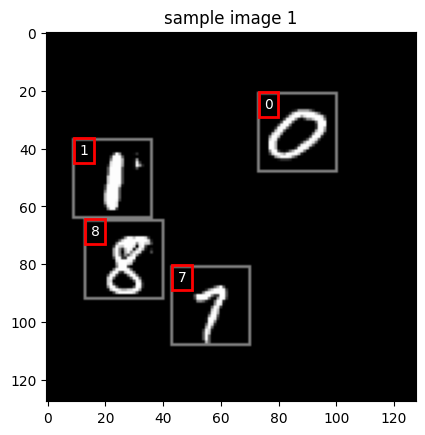

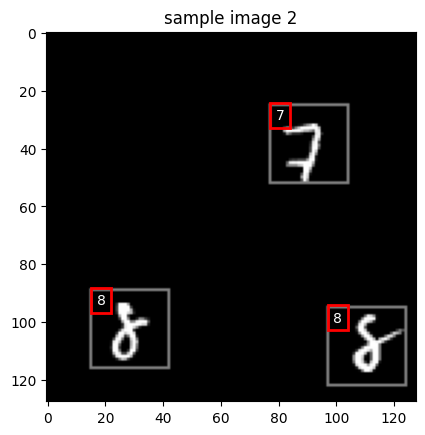

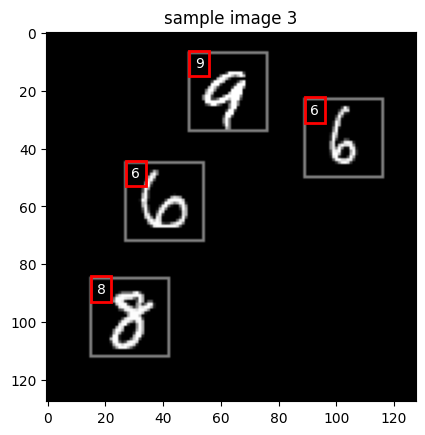

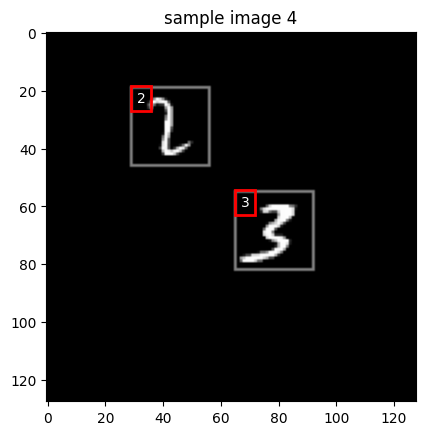

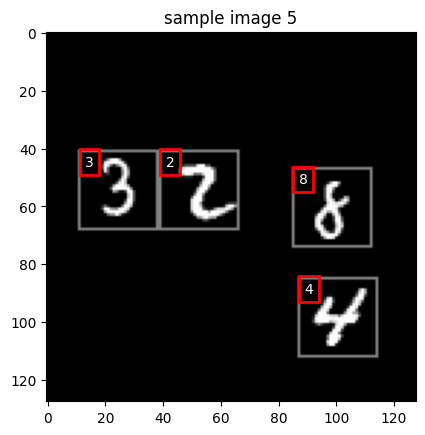

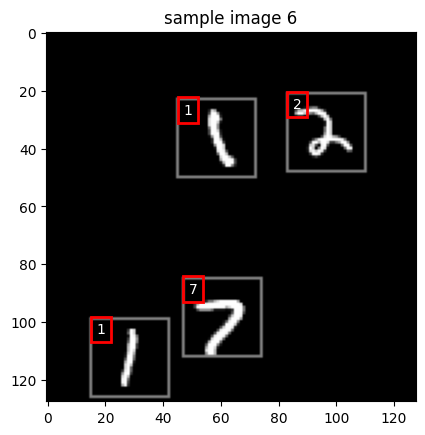

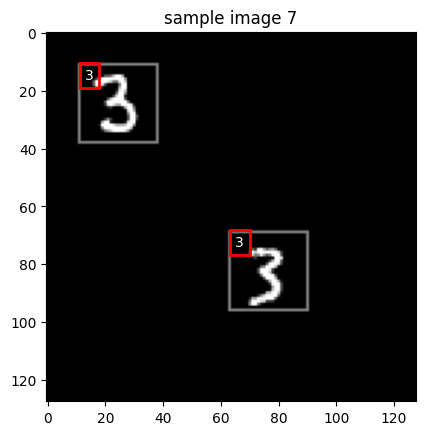

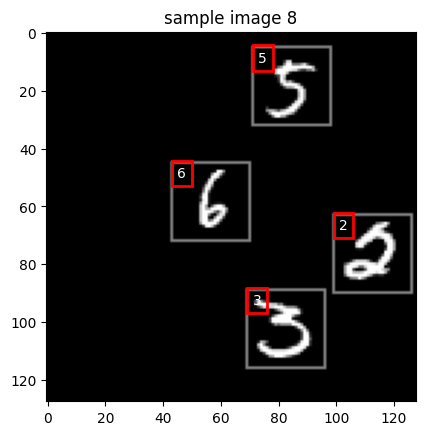

In [5]:
def unet_crop_imgs(imgs, unet, device):
    unet.eval()
    probmap = unet.get_prob(imgs)
    b, _, h, w = probmap.shape
    masks = torch.zeros((b, 1, h, w)).to(device)
    masks[:, 0, :, :] = probmap[:, 1, :, :]
    masks = torch.where(masks > CROP_THRES, 1, 0)

    imgs = imgs.cpu().detach()
    masks = masks.cpu().detach()
    cropped_imgs_list = list()

    for i in range(b):
        mask = masks[i]
        img = imgs[i]
        crop_size, _ = CROPPED_IMG_SIZE
        grid_size = 2

        left_walk_cropped_coord = list()
        right_walk_cropped_coord = list()
        left_walk_mask = mask.clone().detach()
        right_walk_mask = mask.clone().detach()
        for y in range((h-crop_size) // grid_size):
            for x in range((w-crop_size) // grid_size):
                # scan the map from left to right
                yy = y * grid_size
                xx = x * grid_size
                cnt = left_walk_mask[0, yy:yy+crop_size, xx:xx+crop_size].sum().cpu().item()
                if cnt > 0.9 * crop_size * crop_size:
                    offset_x = xx+grid_size//2
                    offset_y = yy+grid_size//2
                    if offset_x + crop_size > w:
                        offset_x = w - crop_size
                    if offset_y + crop_size > h:
                        offset_y = h - crop_size
                    left_walk_cropped_coord.append((offset_y, offset_x))
                    left_walk_mask[0, yy:yy+crop_size, xx:xx+crop_size] = 0

                # scan the map from right to left
                yy = y * grid_size
                xx = w - crop_size - x * grid_size
                cnt = right_walk_mask[0, yy:yy+crop_size, xx:xx+crop_size].sum().cpu().item()
                if cnt > 0.9 * crop_size * crop_size:
                    offset_x = xx+grid_size//2
                    offset_y = yy+grid_size//2
                    if offset_x + crop_size > w:
                        offset_x = w - crop_size
                    if offset_y + crop_size > h:
                        offset_y = h - crop_size
                    right_walk_cropped_coord.append((offset_y, offset_x))
                    right_walk_mask[0, yy:yy+crop_size, xx:xx+crop_size] = 0
        if len(left_walk_cropped_coord) >= len(right_walk_cropped_coord):
            cropped_coord = left_walk_cropped_coord
        else:
            cropped_coord = right_walk_cropped_coord

        cropped_imgs = list()
        for y, x in cropped_coord:
            cropped_img = img[:, y:y+crop_size, x:x+crop_size]
            cropped_imgs.append((y/h, x/w, cropped_img))
        cropped_imgs_list.append(cropped_imgs)
    return cropped_imgs_list

def test_crop_and_classify(unet, classify_net, device):
    loader = PredictionSetLoader(TEST_DIR)
    imgs, _ = loader.sample(8)
    imgs = imgs.to(device)
    cropped_imgs_list = unet_crop_imgs(imgs, unet, device)

    probmap = unet.get_prob(imgs)
    b, _, h, w = probmap.shape
    masks = torch.zeros((b, 1, h, w)).to(device)
    masks[:, 0, :, :] = probmap[:, 1, :, :]
    masks = torch.where(masks > CROP_THRES, 1, 0)

    b, _, _, _ = imgs.shape
    for i in range(b):
        img = imgs[i].detach().cpu()
        _, h, w = img.shape

        cropped_imgs = cropped_imgs_list[i]
        crop_size, _ = CROPPED_IMG_SIZE
        batch_cropped_imgs = list()
        batch_coord = list()
        for y, x, cropped_img in cropped_imgs:
            batch_cropped_imgs.append(cropped_img)
            batch_coord.append((y,x))
        batch_cropped_imgs = torch.stack(batch_cropped_imgs).float()
        batch_cropped_imgs = batch_cropped_imgs.to(device)
        preb = classify_net.get_max(batch_cropped_imgs).cpu().numpy()

        for c, (y, x) in zip(preb, batch_coord):
            x = round(w * x)
            y = round(h * y)
            img[0, y:y+crop_size, x] = 0.5
            img[0, y, x:x+crop_size] = 0.5
            img[0, y:y+crop_size, x+crop_size-1] = 0.5
            img[0, y+crop_size-1, x:x+crop_size] = 0.5
            plt.text(x+2, y+5, str(c), color="white",
                     bbox=dict(fill=False, edgecolor="red", linewidth=2))
        plt.imshow(img.permute(1, 2, 0), cmap="gray")
        plt.title("sample image {}".format(i+1))
        plt.show()

test_crop_and_classify(unet, classify_net, device)

## step6. 預測作業資料

In [6]:
def crop_and_predict(unet, classify_net, device):
    unet.eval()
    classify_net.eval()
    loader = PredictionSetLoader(TEST_DIR)

    pred_result = dict()
    while 1:
        imgs, paths = loader.sample(256)
        imgs = imgs.to(device)
        cropped_imgs_list = unet_crop_imgs(imgs, unet, device)

        for idx, cropped_imgs in enumerate(cropped_imgs_list):
            batch_cropped_imgs = list()
            batch_coord = list()

            for y, x, cropped_img in cropped_imgs:
                batch_cropped_imgs.append(cropped_img)
                batch_coord.append((y,x))
            batch_cropped_imgs = torch.stack(batch_cropped_imgs).float()
            batch_cropped_imgs = batch_cropped_imgs.to(device)
            preb = classify_net.get_max(batch_cropped_imgs).cpu().numpy()

            result = list()
            for c, (y, x) in zip(preb, batch_coord):
                result.append((c, y, x))
            path = paths[idx]
            pred_result[path] = result
        print("Processed {} images.".format(len(pred_result)))

        if loader.end:
            break
    print("done!")

    csv_str = "IMAGE_index,class,x,y\n"
    for key in sorted(pred_result.keys()):
        result = pred_result[key]
        result.sort(key=lambda x: x[0])
        img_index = key[len(TEST_DIR)+1:]
        for c, y, x in result:
            csv_str += "{},{},{},{}\n".format(img_index, c, x, y)
    csv_str = csv_str[:-1]
    return csv_str

result = crop_and_predict(unet, classify_net, device)
with open("HW6_prob1.csv", "w") as f:
    f.write(result)

Processed 256 images.
Processed 512 images.
Processed 768 images.
Processed 1024 images.
Processed 1280 images.
Processed 1536 images.
Processed 1792 images.
Processed 2048 images.
Processed 2304 images.
Processed 2560 images.
Processed 2816 images.
Processed 3072 images.
Processed 3328 images.
Processed 3584 images.
Processed 3840 images.
Processed 4096 images.
Processed 4352 images.
Processed 4608 images.
Processed 4864 images.
Processed 5120 images.
Processed 5376 images.
Processed 5632 images.
Processed 5888 images.
Processed 6144 images.
Processed 6400 images.
Processed 6656 images.
Processed 6912 images.
Processed 7168 images.
Processed 7424 images.
Processed 7680 images.
Processed 7936 images.
Processed 8192 images.
Processed 8448 images.
Processed 8704 images.
Processed 8960 images.
Processed 9216 images.
Processed 9472 images.
Processed 9728 images.
Processed 9984 images.
Processed 10240 images.
Processed 10496 images.
Processed 10752 images.
Processed 11008 images.
Processed 